In [ ]:
!pip install --upgrade pip
!pip install kaggle tensorflow matplotlib scikit-learn seaborn opencv-python



In [ ]:
!pip install pydot graphviz


In [1]:
# 1) upload du kaggle.json (exécuter dans une cellule Colab)
from google.colab import files
files.upload()  # uploader kaggle.json

# 2) déplacer et permissions
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# 3) télécharger et unzip
!kaggle datasets download -d benaddym/amazigh-handwritten-character-database-amhcd -p /content/data --unzip



Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/benaddym/amazigh-handwritten-character-database-amhcd
License(s): other
  0% 0.00/67.9M [00:00<?, ?B/s]
100% 67.9M/67.9M [00:00<00:00, 965MB/s]


In [2]:
import pathlib

data_dir = pathlib.Path("/content/data")  # adapter si c’est "archive" ou autre
classes = sorted([p.name for p in data_dir.iterdir() if p.is_dir()])
print("Classes disponibles:", classes)


Classes disponibles: ['AMHCD_64', 'amhcd_64', 'labels']


Nombre de classes détectées: 33
Exemple classes: ['ya', 'yab', 'yach', 'yad', 'yadd']


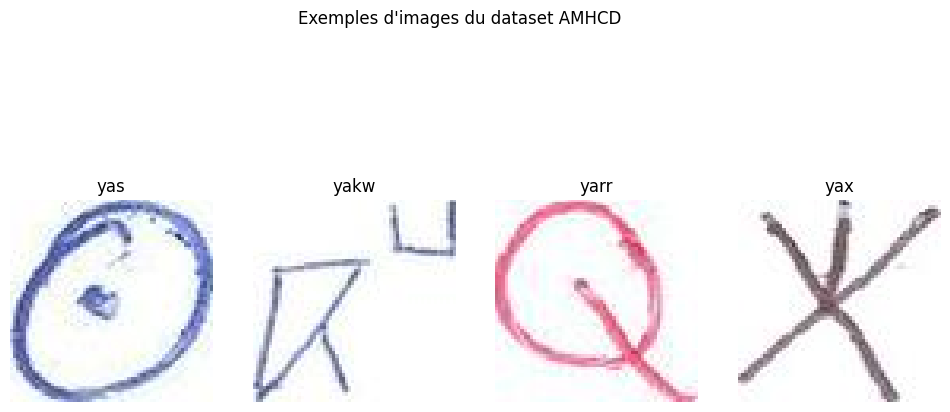

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [3]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import pathlib

# chemin racine
data_dir = pathlib.Path("/content/data/AMHCD_64/AMHCD_64")

# lister les classes
classes = sorted([p.name for p in data_dir.iterdir() if p.is_dir()])
print("Nombre de classes détectées:", len(classes))
print("Exemple classes:", classes[:5])

# choisir jusqu'à 4 classes
selected_classes = random.sample(classes, min(4, len(classes)))

plt.figure(figsize=(12, 6))

for i, cls in enumerate(selected_classes):
    # récupérer toutes les images de cette classe
    img_files = list((data_dir/cls).glob("*.jpeg")) + list((data_dir/cls).glob("*.jpg")) + list((data_dir/cls).glob("*.png"))
    if not img_files:
        print(f"Aucune image trouvée dans la classe {cls}")
        continue

    # choisir une image au hasard
    img_path = random.choice(img_files)
    img = mpimg.imread(img_path)

    plt.subplot(1, len(selected_classes), i+1)
    plt.imshow(img)
    plt.title(cls)
    plt.axis("off")
    plt.savefig("images_exemple.png")

plt.suptitle("Exemples d'images du dataset AMHCD")
plt.show()
from google.colab import files
files.download("images_exemple.png")

# Step 1 — Prepare the dataset (loading & preprocessing)


In [4]:
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split


# Paramètres globaux

IMG_SIZE = 32       # pour LeNet-5 original
BATCH_SIZE = 64
AUTOTUNE = tf.data.AUTOTUNE


# Récupérer chemins et labels

all_image_paths = []
all_labels = []

classes = sorted([p.name for p in data_dir.iterdir() if p.is_dir()])
label_to_index = {name: idx for idx, name in enumerate(classes)}

for cls in classes:
    img_files = list((data_dir/cls).glob("*.jpeg")) + list((data_dir/cls).glob("*.jpg")) + list((data_dir/cls).glob("*.png"))
    for f in img_files:
        all_image_paths.append(str(f))
        all_labels.append(label_to_index[cls])

all_image_paths = np.array(all_image_paths)
all_labels = np.array(all_labels)

print("Total images:", len(all_image_paths))
print("Nombre de classes:", len(classes))


Total images: 25740
Nombre de classes: 33


# Step 2 — Split into train / validation / test


In [5]:
train_paths, temp_paths, train_labels, temp_labels = train_test_split(
    all_image_paths, all_labels, test_size=0.30, stratify=all_labels, random_state=42
)

val_paths, test_paths, val_labels, test_labels = train_test_split(
    temp_paths, temp_labels, test_size=0.5, stratify=temp_labels, random_state=42
)

print("Train:", len(train_paths), "Validation:", len(val_paths), "Test:", len(test_paths))


Train: 18018 Validation: 3861 Test: 3861


# Step 3 — Create TensorFlow datasets


In [6]:
def decode_and_resize(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_image(img, channels=3, expand_animations=False)
    img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])
    img = tf.cast(img, tf.float32) / 255.0
    return img, label

def make_dataset(paths, labels, shuffle=True, augment=False):
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(paths))
    ds = ds.map(decode_and_resize, num_parallel_calls=AUTOTUNE)
    if augment:
        aug = tf.keras.Sequential([
            tf.keras.layers.RandomFlip("horizontal"),
            tf.keras.layers.RandomRotation(0.05),
        ])
        ds = ds.map(lambda x,y: (aug(x, training=True), y), num_parallel_calls=AUTOTUNE)
    ds = ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)
    return ds

train_ds = make_dataset(train_paths, train_labels, augment=True)
val_ds   = make_dataset(val_paths, val_labels, shuffle=False)
test_ds  = make_dataset(test_paths, test_labels, shuffle=False)


# Step 4 — Implement LeNet-5 (RGB version)


In [7]:
from tensorflow.keras import layers, models

def build_lenet5(input_shape=(IMG_SIZE, IMG_SIZE, 3), num_classes=len(classes)):
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv2D(6, kernel_size=5, activation="relu")(inputs)     # 28x28x6
    x = layers.AveragePooling2D(pool_size=2)(x)                        # 14x14x6
    x = layers.Conv2D(16, kernel_size=5, activation="relu")(x)         # 10x10x16
    x = layers.AveragePooling2D(pool_size=2)(x)                        # 5x5x16
    x = layers.Flatten()(x)
    x = layers.Dense(120, activation="relu")(x)
    x = layers.Dense(84, activation="relu")(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)
    model = models.Model(inputs, outputs, name="LeNet5_RGB")
    return model

model = build_lenet5()
model.summary()


Model: "LeNet5_RGB"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 28, 28, 6)      │           456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d               │ (None, 14, 14, 6)      │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 10, 10, 16)     │         2,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_1             │ (None, 5, 5, 16)       │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 400)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 120)            │        48,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 84)             │        10,164 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 33)             │         2,805 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 63,961 (249.85 KB)

 Trainable params: 63,961 (249.85 KB)

 Non-trainable params: 0 (0.00 B)

# Step 5 — Compile and train

In [8]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30
)


Epoch 1/30
282/282 ━━━━━━━━━━━━━━━━━━━━ 20s 53ms/step - accuracy: 0.1372 - loss: 3.0898 - val_accuracy: 0.5815 - val_loss: 1.4272
Epoch 2/30
282/282 ━━━━━━━━━━━━━━━━━━━━ 12s 43ms/step - accuracy: 0.5947 - loss: 1.4130 - val_accuracy: 0.7552 - val_loss: 0.8807
Epoch 3/30
282/282 ━━━━━━━━━━━━━━━━━━━━ 12s 42ms/step - accuracy: 0.7264 - loss: 0.9582 - val_accuracy: 0.8324 - val_loss: 0.6144
Epoch 4/30
282/282 ━━━━━━━━━━━━━━━━━━━━ 12s 42ms/step - accuracy: 0.7739 - loss: 0.8084 - val_accuracy: 0.8386 - val_loss: 0.5770
Epoch 5/30
282/282 ━━━━━━━━━━━━━━━━━━━━ 21s 43ms/step - accuracy: 0.8223 - loss: 0.6447 - val_accuracy: 0.8863 - val_loss: 0.4239
Epoch 6/30
282/282 ━━━━━━━━━━━━━━━━━━━━ 12s 43ms/step - accuracy: 0.8501 - loss: 0.5230 - val_accuracy: 0.9055 - val_loss: 0.3384
Epoch 7/30
282/282 ━━━━━━━━━━━━━━━━━━━━ 12s 42ms/step - accuracy: 0.8671 - loss: 0.4551 - val_accuracy: 0.9184 - val_loss: 0.2874
Epoch 8/30
282/282 ━━━━━━━━━━━━━━━━━━━━ 12s 42ms/step - accuracy: 0.8792 - loss: 0.4103 - 

In [10]:
test_loss, test_acc = model.evaluate(test_ds, verbose=0)
print("Perte test :", test_loss)
print("Accuracy test :", test_acc)


Perte test : 0.1277172863483429
Accuracy test : 0.9639989733695984


# Step-6- Visualization

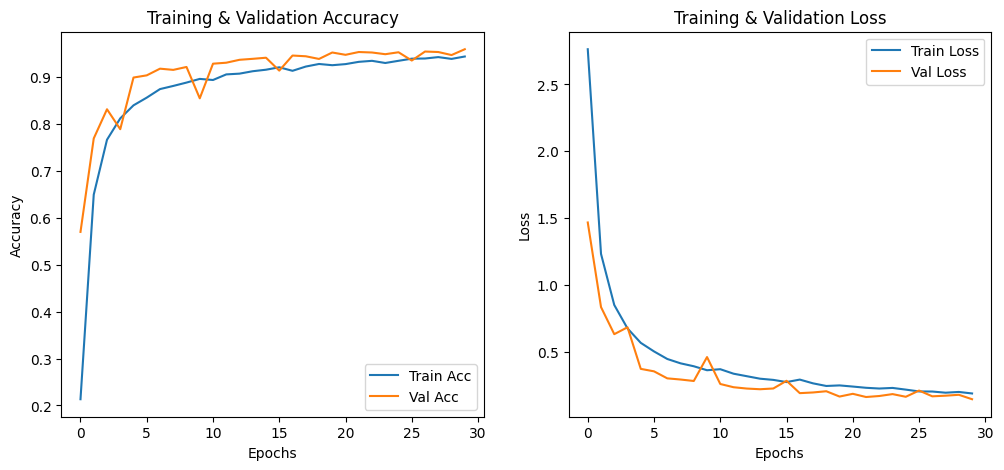

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# --- 1) Courbes Loss & Accuracy ---
def plot_training_curves(history):
    plt.figure(figsize=(12, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history["accuracy"], label="Train Acc")
    plt.plot(history.history["val_accuracy"], label="Val Acc")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.title("Training & Validation Accuracy")

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history["loss"], label="Train Loss")
    plt.plot(history.history["val_loss"], label="Val Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Training & Validation Loss")
    plt.savefig("training_curves.png")


    plt.show()
plot_training_curves(history)
from google.colab import files
files.download("training_curves.png")



In [ ]:
cm = confusion_matrix(y_true, y_pred)
print(cm.shape)
print(cm.sum(axis=1))  # doit être égal à 117 pour chaque ligne


(33, 33)
[117 117 117 117 117 117 117 117 117 117 117 117 117 117 117 117 117 117
 117 117 117 117 117 117 117 117 117 117 117 117 117 117 117]


In [ ]:
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100


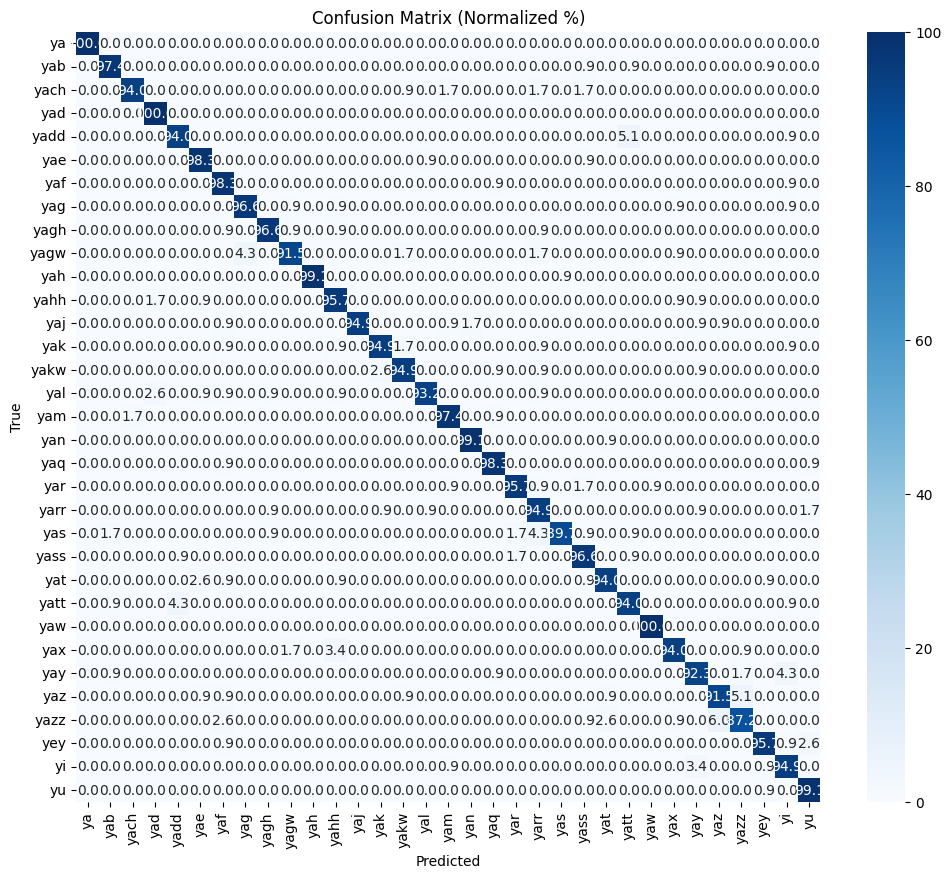

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
plt.figure(figsize=(12, 10))
sns.heatmap(cm_percent, annot=True, fmt=".1f", cmap="Blues",
            xticklabels=classes, yticklabels=classes)
plt.savefig("confusion_matrix_percent.pdf")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (Normalized %)")
plt.show()
from google.colab import files
files.download("confusion_matrix_percent.pdf")